<a href="https://colab.research.google.com/github/chaeyeon00/Computer-Vision/blob/main/ResNet_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **ResNet Model 구현**

In [ ]:
import torch
import torch.nn as nn
from torch import Tensor

In [ ]:
# Layer 생성에 대한 공통 함수 생성
"""
    3*3 convolution fucntion
    args : in_channels: in_channels (Input 채널수)
           out_channels: out_channels (Output채널수)
"""
def conv3x3(in_channels, out_channels, stride=1, groups=1, dilation=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)
"""
    1*1 convolution fucntion
"""
def conv1x1(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
"""
  배치 정규화 fucntion
"""
def norm_layer(out_channels) :
    return nn.BatchNorm2d(out_channels)

In [ ]:
class BasicBlock(nn.Module):
   # 18 layers ~ 30 layers인 경우 BasicBlock
    expansion = 1

    def __init__(self, inplanes, planes, stride=1,downsample = None)  -> None:
        """  초기화 
         - inplanes: Input 채널수
         - planes:  Output채널수
        """
        super().__init__()
        # Basic Block의 구조 ( 2개 묶음으로 layer생성)
        self.conv1 = conv3x3(inplanes, planes, stride)  
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x :Tensor) -> Tensor:
        identity = x

        #residual_function Start
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        #residual_function end
        
        # short connection
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # residual_function 적용 후 ReLU 적용(Y? ReLU통과 시, 양의 값만 남기에 RF적용 의미없음)
        out += identity
        out = self.relu(out)

        return out

In [ ]:
class BottleNeck(nn.Module):
   # 50 layers이상인 경우 BottleNeck
    expansion = 4

    def __init__(self, inplanes, planes, stride=1,downsample = None):
        """  초기화 
         - inplanes: Input 채널수
         - planes:  Output채널수
        """
        super().__init__()
        # Basic Block의 구조 ( 3개 묶음으로 layer생성)
        self.conv1 = conv3x3(inplanes, planes, stride)  
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes * BasicBlock.expansion)
        self.bn2 = norm_layer(planes * BasicBlock.expansion)
        self.conv3 = conv1x1(planes * self.expansion) 
        self.bn3 = norm_layer(planes * self.expansion)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x :Tensor) -> Tensor:
        identity = x

        #residual_function Start
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
                
        #residual_function end
        
        # short connection
        if self.downsample is not None:
            identity = self.downsample(x)
            
        # residual_function 적용 후 ReLU 적용(Y? ReLU통과 시, 양의 값만 남기에 RF적용 의미없음)
        out += identity
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, init_weights=False):
        super(ResNet, self).__init__()

        self.in_channels = 64 # In 채널 수


        # conv1 layer 정의
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        """
        block 형태로 layer 생성
        각 block들을 통하여 채널수 변경(64->128->256->512)
        block별 layer생성 완료 후 AdaptiveAvgPool2d를 통하여  (n, 512, 1, 1) 형태로 변경
        conv3_x ~ conv5_x downsampling 적용 되어질 예정 
        """
        self.conv2_x = self._make_layer(block, 64, layers[0])
        self.conv3_x = self._make_layer(block, 128, layers[1], stride=2) 
        self.conv4_x = self._make_layer(block, 256, layers[2], stride=2)
        self.conv5_x = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # 각 모델의 weights 초기화 
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)



    def _make_layer(self, block, planes, blocks, stride=1) -> nn.Sequential:
        """
        layers 생성 처리 
        - block: block종류(basic block or bottle neck block)
        - planes: input fittlers
        - blocks: 블록의 갯수
        """

        #downsample : skip layer(downsample 여부)
        downsample = None

        
        #  입력 shaep와 output shape가 다른 경우 skip layer처리
        # stride=2로 downsampling 진행
        # 위의 conv3_x ~ conv5_x downsampling 적용되어질 예정
        if stride != 1 or self.in_channels != planes * block.expansion :
            downsample = nn.Sequential(
                conv1x1(self.in_channels, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        # 블록 생성 시작 
        # downsampling 필요 유무에 따른  layer생성
        layers.append(block(self.in_channels, planes, stride, downsample))
        self.in_channels = planes * block.expansion # in_channels 업데이트
        # 동일 블록 반복(downsampling 없는 layer) 
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, planes))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # conv1 layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [ ]:
#ResNet 아키텍쳐에 따른 함수 
## layer의 수에 따라 group되어지는 layers수가 다름
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])
def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(BottleNeck, [3, 4, 6, 3])

def ResNet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def ResNet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

**이미지 로드 및 정규화처리**

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import utils
import numpy as np


In [ ]:
#이미지 다운
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# 채널 별 mean 계산
def get_mean(dataset):
  meanRGB = [np.mean(image.numpy(), axis=(1,2)) for image,_ in dataset]
  meanR = np.mean([m[0] for m in meanRGB])
  meanG = np.mean([m[1] for m in meanRGB])
  meanB = np.mean([m[2] for m in meanRGB])
  return [meanR, meanG, meanB]

# 채널 별 std 계산
def get_std(dataset):
  stdRGB = [np.std(image.numpy(), axis=(1,2)) for image,_ in dataset]
  stdR = np.mean([s[0] for s in stdRGB])
  stdG = np.mean([s[1] for s in stdRGB])
  stdB = np.mean([s[2] for s in stdRGB])
  return [stdR, stdG, stdB]

In [ ]:
train_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(get_mean(train_dataset), get_std(train_dataset))])
test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(get_mean(test_dataset), get_std(test_dataset))])

# trainsform 정의
train_dataset.transform = train_transforms
test_dataset.transform = test_transforms

In [ ]:
# dataloader 정의
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

image indices: 23182


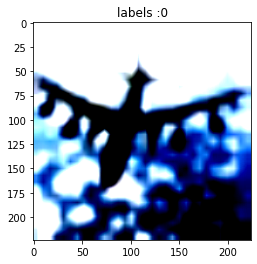

In [ ]:
# 이미지 확인

def show(img, y=None, color=True):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels :' + str(y))

idx = np.random.randint(0, len(train_dataset))
print('image indices:',idx)

x_grid = train_dataset[idx][0]
y_grid = train_dataset[idx][1]

x_grid = utils.make_grid(x_grid)

show(x_grid, y_grid)

**ResNet 아키텍처 확인**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 학습 환경 설정
model = ResNet18().to(device)

In [ ]:
x = torch.randn(3, 3, 224, 224).to(device)
print(x.shape)
output = model(x)
print(model)

torch.Size([3, 3, 224, 224])
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2_x): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [ ]:
from torchsummary import summary
summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

**CIFAR10 이미지 적용**

In [ ]:
import torch.optim as optim

In [ ]:
#train 학습을 위한 lr,optimizer 정의
lr = 0.0001
num_epochs = 5
optimizer = optim.Adam(model.parameters(), lr=lr) # Adam 사용
#optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)

loss_function = nn.CrossEntropyLoss().to(device)

In [ ]:
params = {
    'num_epochs':num_epochs,
    'optimizer':optimizer,
    'loss_function':loss_function,
    'train_dataloader':train_dataloader,
    'test_dataloader': test_dataloader,
    'device':device
}

In [ ]:
model = ResNet18().to(device)

In [ ]:
learning_rate = 0.1
num_epoch = 150
model_name = 'model.pth'

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)

train_loss = 0
valid_loss = 0
correct = 0
total_cnt = 0
best_acc = 0

In [ ]:
def train(model, params):
    loss_function=params["loss_function"]
    train_dataloader=params["train_dataloader"]
    test_dataloader=params["test_dataloader"]
    device=params["device"]

    for epoch in range(0, num_epochs):
      for i, data in enumerate(train_dataloader, 0):
        # train dataloader 로 불러온 데이터에서 이미지/ 라벨을 분리
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        #가중치를 초기화
        optimizer.zero_grad() 

        # forward + back propagation 연산
        outputs = model(inputs)
        train_loss = loss_function(outputs, labels)
        train_loss.backward()
        optimizer.step()

      # test accuracy 
      total = 0
      correct = 0
      accuracy = []
      for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 결과값 연산
        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss = loss_function(outputs, labels).item()
        accuracy.append(100 * correct/total)

      # 학습 결과 출력
      print('Epoch: %d/%d, Train loss: %.6f, Test loss: %.6f, Accuracy: %.2f'
       %(epoch+1, num_epochs, train_loss.item(), test_loss, 100*correct/total))

In [ ]:
train(model, params)

Epoch: 1/5, Train loss: 1.123202, Test loss: 1.260744, Accuracy: 59.76
Epoch: 2/5, Train loss: 0.732144, Test loss: 0.957393, Accuracy: 69.83
Epoch: 3/5, Train loss: 0.463950, Test loss: 0.949835, Accuracy: 73.80
Epoch: 4/5, Train loss: 0.435610, Test loss: 0.803791, Accuracy: 76.08
Epoch: 5/5, Train loss: 0.341475, Test loss: 0.885574, Accuracy: 76.60
